# Stratification corrections and Newton Raphson method to calculate Monin Obukhov length $z/L$

In [1]:
from sympy import symbols, init_printing
import sympy as sp

# Required only in terminal
# init_printing()

In [2]:
from sympy.printing.pycode import pycode
from IPython.display import Code, display


def show_python(expr):
    code = pycode(expr).replace("math", "np").replace(r"\xi_", "xi")
    return display(Code(code, language="python"))

In [3]:
z1, z0, z = symbols("z_1 z_0 z", real=True, positive=True)
L, xi = symbols(r"L \xi", real=True)

In [4]:
z.is_positive

True

In [5]:
L.is_positive

Let's create dummy variables depending on Monin Obukhov length $L$ (because [Sympy cannot refine piecewise functions](https://github.com/sympy/sympy/issues/9384))

In [6]:
Lp = symbols("L", positive=True)
Ln = symbols("L", negative=True)

In [7]:
Lp.is_positive

True

In [8]:
Ln.is_positive

False

![](https://github.com/ashwinvis/talks/raw/master/images/most_mo_func.png)

## Symbols

- $\xi = z/L$
- $L = $ Obukhov length
- $Ri = $ Richardson number

# Momentum

## Computing $\phi_m(\xi)$

In [9]:
phi_m = sp.Piecewise(
    (1 + 5 * xi, xi >= 0), (1 / sp.root((1 - 16 * xi), 4), xi < 0)
)
phi_m

Piecewise((5*\xi + 1, \xi >= 0), ((1 - 16*\xi)**(-1/4), True))

<string>:1: RuntimeWarning: invalid value encountered in double_scalars


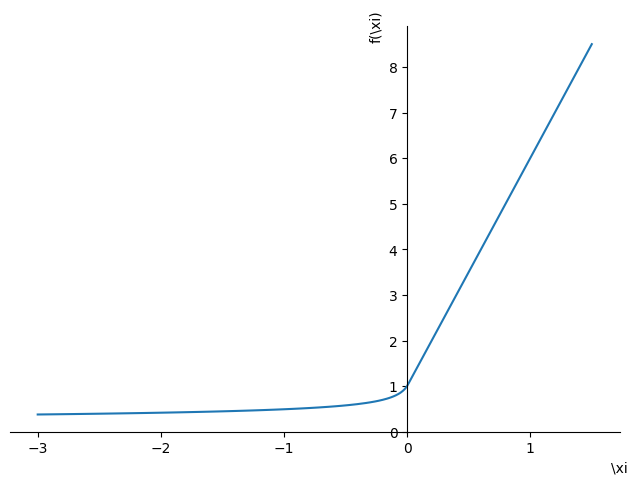

In [10]:
# import numpy as np

# np.seterr('raise')
# np.seterr('warn')
sp.plot(phi_m, (xi, -3, 1.5), axis_center=(0, 0))

In [11]:
show_python(phi_m)

((5*\xi + 1) if (\xi >= 0) else ((1 - 16*\xi)**(-1/4)))

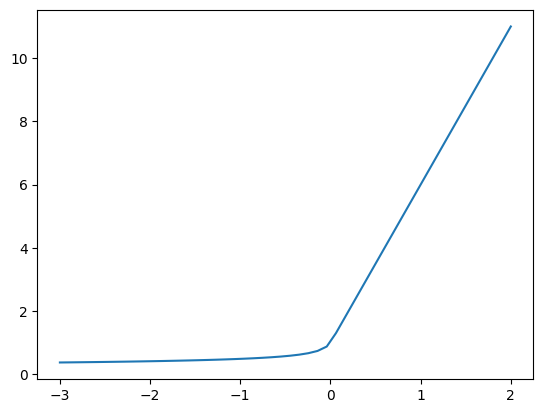

In [15]:
import matplotlib.pyplot as plt
import numpy as np


xs = np.linspace(-3, 2)


@np.vectorize
def phi_m_numpy(xi):
    return eval(pycode(phi_m).replace(r"\xi", "xi"), locals())


plt.plot(xs, phi_m_numpy(xs))

In [16]:
psi_m_int = (1 - phi_m) / xi

psi_m = sp.integrate(psi_m_int, (xi, 0, z / L))

In [17]:
psi_m

Piecewise((2*log((1 - 16*Min(0, z/L))**(1/4) + 1) + log(sqrt(1 - 16*Min(0, z/L)) + 1) - 2*atan((1 - 16*Min(0, z/L))**(1/4)) - 3*log(2) + pi/2, z/L < 0), (5*Min(0, z/L) - 5*z/L, True))

In [18]:
psi_m.refine(sp.Q.zero(z)).subs(z, 0)

0

In [19]:
psi_m_stable = psi_m.refine(sp.Q.positive(L)).subs(L, Lp)
psi_m_stable

-5*z/L

In [20]:
psi_m_unstable = psi_m.refine(sp.Q.negative(L)).subs(L, Ln)
psi_m_unstable

2*log((1 - 16*z/L)**(1/4) + 1) + log(sqrt(1 - 16*z/L) + 1) - 2*atan((1 - 16*z/L)**(1/4)) - 3*log(2) + pi/2

### Substitute $\sqrt[4]{1 - 16 z/L} \to \xi_4$

In [21]:
xi4 = symbols(r"\xi_4", positive=True)

In [22]:
(psi_m_unstable_param := psi_m_unstable.subs(sp.root(1 - 16 * z / Ln, 4), xi4))

2*log(\xi_4 + 1) + log(\xi_4**2 + 1) - 2*atan(\xi_4) - 3*log(2) + pi/2

In [23]:
show_python(sp.logcombine(psi_m_unstable_param))

np.log((1/8)*(xi4 + 1)**2*(xi4**2 + 1)) - 2*np.atan(xi4) + (1/2)*np.pi

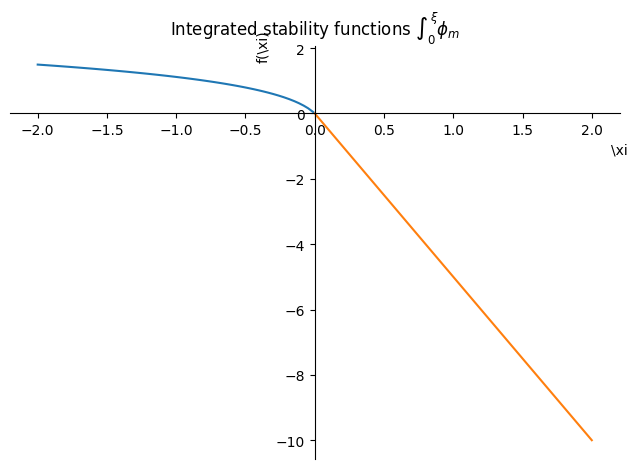

In [24]:
p1 = sp.plot(
    psi_m_unstable.subs(z / Ln, xi),
    (xi, -2, -0.01),
    show=False,
    title=r"Integrated stability functions $\int_0^{\xi} \phi_m$",
    label="unstable",
)
p2 = sp.plot(
    psi_m_stable.subs(z / Lp, xi), (xi, 0, 2), show=False, label="stable"
)
p1.append(p2[0])
p1.show()

### Compare with [Basu (2018)](https://bitbucket.org/sukantabasu/hybridwind/src/master/HybridWind.m)

In [26]:
basu_unstable = (
    2 * sp.log((1 + xi4) / 2)
    + sp.log((1 + xi4 ** 2) / 2)
    - 2 * sp.atan(xi4)
    + sp.pi / 2
)
basu_unstable

2*log(\xi_4/2 + 1/2) + log(\xi_4**2/2 + 1/2) - 2*atan(\xi_4) + pi/2

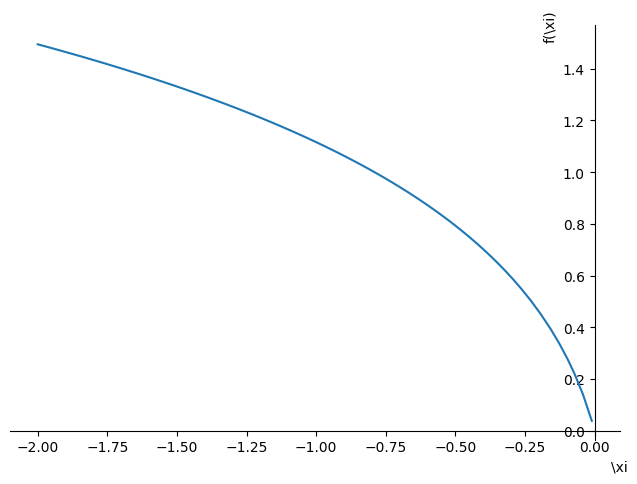

In [27]:
sp.plot(basu_unstable.subs(xi4, sp.root(1 - 16 * xi, 4)), (xi, -2, -0.01))

In [29]:
(psi_m_unstable_param - basu_unstable).simplify()

0

Hence, both expressions are identical.

## Computing $\Psi_M(z_0, z_1, L)$

In [30]:
def psi_m_stable_at(x):
    return psi_m_stable.subs(z / Lp, x)


PsiM_stable = sp.log(z1 / z0) - psi_m_stable_at(z1 / L) + psi_m_stable_at(z0 / L)
PsiM_stable

log(z_1/z_0) - 5*z_0/L + 5*z_1/L

In [31]:
def f_psi_m_unstable(x):
    return psi_m_unstable.subs(z / Ln, x)


PsiM_unstable = (
    sp.log(z1 / z0) - f_psi_m_unstable(z1 / L) + f_psi_m_unstable(z0 / L)
)
PsiM_unstable

log(z_1/z_0) + 2*log((1 - 16*z_0/L)**(1/4) + 1) + log(sqrt(1 - 16*z_0/L) + 1) - 2*log((1 - 16*z_1/L)**(1/4) + 1) - log(sqrt(1 - 16*z_1/L) + 1) - 2*atan((1 - 16*z_0/L)**(1/4)) + 2*atan((1 - 16*z_1/L)**(1/4))

# Heat

In [32]:
phi_h = sp.Piecewise((1 + 5 * xi, xi >= 0), (sp.root((1 - 16 * xi), -2), xi < 0))
phi_h

Piecewise((5*\xi + 1, \xi >= 0), (1/sqrt(1 - 16*\xi), True))

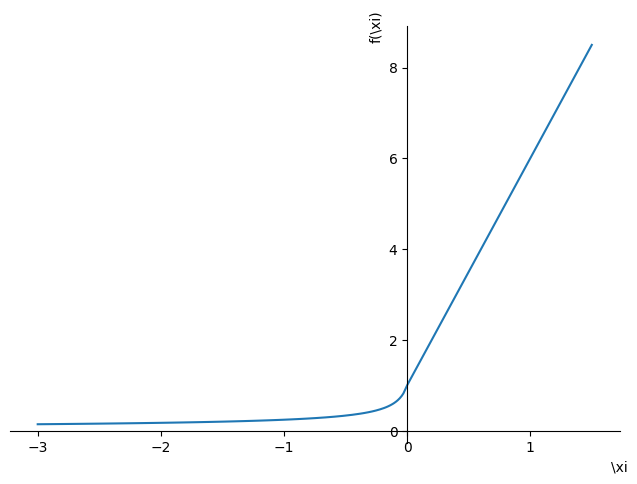

In [33]:
sp.plot(phi_h, (xi, -3, 1.5), axis_center=(0, 0))

In [34]:
psi_h_int = (1 - phi_h) / xi

psi_h = sp.integrate(psi_h_int, (xi, 0, z / L))

In [35]:
psi_h

Piecewise((2*log(sqrt(1 - 16*Min(0, z/L)) + 1) - 2*log(2), z/L < 0), (5*Min(0, z/L) - 5*z/L, True))

In [36]:
psi_h.refine(sp.Q.zero(z)).subs(z, 0)

0

In [37]:
psi_h_stable = psi_h.refine(sp.Q.positive(L)).subs(L, Lp)
psi_h_stable

-5*z/L

In [38]:
psi_h_unstable = psi_h.refine(sp.Q.negative(L)).subs(L, Ln)
psi_h_unstable

2*log(sqrt(1 - 16*z/L) + 1) - 2*log(2)

### Substitute $\sqrt{1 - 16 z/L} \to \xi_2$

In [42]:
xi2 = symbols(r"\xi_2", positive=True)

In [44]:
(psi_h_unstable_param := psi_h_unstable.subs(sp.root(1 - 16 * z / Ln, 2), xi2))

2*log(\xi_2 + 1) - 2*log(2)

In [45]:
(psi_h_unstable_param := sp.logcombine(psi_h_unstable_param))

log((\xi_2 + 1)**2/4)

In [46]:
show_python(psi_h_unstable_param)

np.log((1/4)*(xi2 + 1)**2)

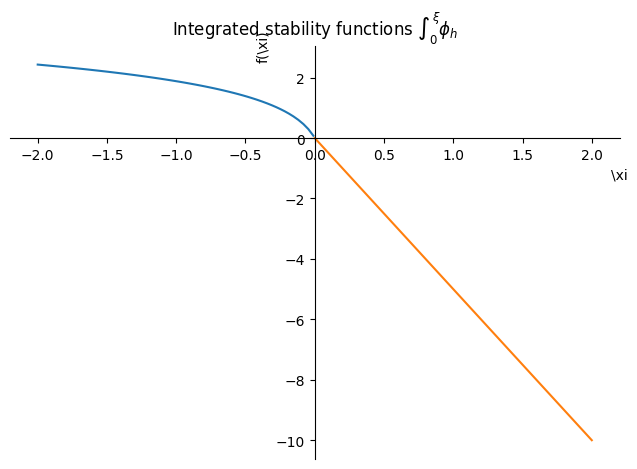

In [47]:
p1 = sp.plot(
    psi_h_unstable.subs(z / Ln, xi),
    (xi, -2, -0.01),
    show=False,
    title=r"Integrated stability functions $\int_0^{\xi} \phi_h$",
    label="unstable",
)
p2 = sp.plot(
    psi_h_stable.subs(z / Lp, xi), (xi, 0, 2), show=False, label="stable"
)
p1.append(p2[0])
p1.show()

## Computing $\Psi_H(z_0, z_1, L)$

In [ ]:
def f_psi_h_stable(x):
    return psi_h_stable.subs(z / Lp, x)


PsiH_stable = sp.log(z1 / z0) - f_psi_h_stable(z1 / L) + f_psi_h_stable(z0 / L)
PsiH_stable

In [ ]:
def f_psi_h_unstable(x):
    return psi_h_unstable.subs(z / Ln, x)


PsiH_unstable = (
    sp.log(z1 / z0) - f_psi_h_unstable(z1 / L) + f_psi_h_unstable(z0 / L)
)
PsiH_unstable

# Richardson number

## Stable

In [ ]:
Ri_b = symbols("Ri_b", real=True)

In [ ]:
Ri_stable = (z1 / L) * (PsiH_stable / PsiM_stable ** 2)

Ri_stable

In [ ]:
(Ri_stable_dL := Ri_stable.diff(L))

In [ ]:
Ri_stable_dL.factor()

In [ ]:
Ri_stable_dL.simplify()

## Unstable

In [ ]:
Ri_unstable = (z1 / L) * (PsiH_unstable / PsiM_unstable ** 2)

Ri_unstable

### Substitute $\sqrt{1 - 16 z_{0,1}/L} \to h_0, h_1$

In [ ]:
h0, h1 = symbols("h_0 h_1", real=True)

In [ ]:
Ri_unstable.subs({sp.sqrt(1 - 16 * z0 / L): h0, sp.sqrt(1 - 16 * z1 / L): h1})

In [ ]:
Ri_unstable.diff(L)

# Newton Raphson

In [ ]:
from sympy.codegen.algorithms import newtons_method
from sympy.codegen.pyutils import render_as_module

# For Fortran
from sympy.codegen.futils import render_as_module as render_as_fortran_mod

In [ ]:
dL, atol = symbols("dL atol")

In [ ]:
f = Ri_b - Ri_stable

expr = L - f / f.diff(L)
algo = newtons_method(expr, L, atol, dL)

In [ ]:
print(render_as_module(algo))

In [ ]:
print(render_as_fortran_mod(algo, "find_ob_len_stable"))

In [ ]:
f = Ri_b - Ri_unstable

expr = L - f / f.diff(L)
algo = newtons_method(expr, L, atol, dL)

#### Note: huge code generated

print(render_as_module(algo))

print(render_as_fortran_mod(algo, 'find_ob_len_stable'))